In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Summary

Here we build models that help the Leuven University Fund (LUF) to predict if a donor would donate to the LUF again after donating for the first time to LUF. <br>

The required data for this notebook is obtained using question2_prepared_data.csv file that is generated in 'Data Preparation & Feature Construction.ipynb'. <br>

So far only 3 classifiers are used namely Random Forests, Logistic Regression and SVM with PCA. <br>

The idea is to train the classifier for high recall while minimizing as much false positives as possible. <br>

TODO: Create a Neural Network classifier using keras package

In [3]:
question2_prepared_data = pd.read_csv('SQLDATA/PYTHON_OUTPUTS/question2_prepared_data.csv')
print(question2_prepared_data.shape)
question2_prepared_data = question2_prepared_data.drop(['Unnamed: 0'], axis=1)
print(question2_prepared_data.shape)
question2_prepared_data.head()

(56897, 131)
(56897, 130)


,PARTNER,XSEXF,XSEXM,ZZAMNT_PAYED,ZLUF_DOCDATE,ZZAMNT_PAYED_NORM,ISK_PERSON,ISK_BIRTHPL,ISK_BU_LANGU,ISK_CNT_ORIGIN,...,ZLUF_LIJST,ZLUF_ORG_ALS_PERSOON,ZLUF_ORG_VERENIGING,ZLUF_SCHENKINTERESSE_ARTnCULTURE,ZLUF_SCHENKINTERESSE_CHILDREN,ZLUF_SCHENKINTERESSE_DEVCOOP,ZLUF_SCHENKINTERESSE_HEALTHCARE,ZLUF_SCHENKINTERESSE_HERITAGE,ZLUF_SCHENKINTERESSE_SCHOLARSHIPS,IS_MULTI_DONOR
0,200000002,0,0,1000.0,2004-07-20,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,200000007,0,0,4000.0,2010-11-02,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,200000010,0,0,100.0,2009-12-22,100.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,200000013,0,0,5000.0,2012-02-28,5000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,200000024,0,0,20000.0,2018-01-03,20000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
question2_prepared_data['IS_MULTI_DONOR'].sum()

14727

14,729 donors out of 56,897 are multi-donors (~26%)

In the below cell we remove some of the features that hindered the performance of the classifier

In [5]:
relevant_cols = list(question2_prepared_data.columns.values)
if "PARTNER" in str(relevant_cols):
    relevant_cols.remove("PARTNER")
if "ZLUF_DOCDATE" in str(relevant_cols):
    relevant_cols.remove("ZLUF_DOCDATE")
if "ZZAMNT_PAYED_NORM" in str(relevant_cols):
    relevant_cols.remove("ZZAMNT_PAYED_NORM")
#if "ZZAMNT_PAYED" in str(relevant_cols):
#    relevant_cols.remove("ZZAMNT_PAYED")

if "ISK_FD_CAT_1" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_1")
if "ISK_FD_CAT_2" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_2")
if "ISK_FD_CAT_3" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_3")
if "ISK_FD_CAT_4" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_4")
if "ISK_FD_CAT_5" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_5")
if "ISK_FD_CAT_6" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_6")
    
if "ISK_FD_SHARED" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_SHARED")    

In [6]:
train_cols = relevant_cols
if "IS_MULTI_DONOR" in str(train_cols):
    train_cols.remove("IS_MULTI_DONOR")

# Random Forest

In [11]:
#Random Forest baseline
train_X_bl, test_X_bl, train_y_bl, test_y_bl = train_test_split(question2_prepared_data[list(train_cols)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X_bl.shape)

rf = RandomForestClassifier()
rf.fit(train_X_bl,train_y_bl)

rf_predictions = rf.predict(test_X_bl)
rf_mc = matthews_corrcoef(rf_predictions, test_y_bl)

df = pd.DataFrame({"a":test_y,"b":rf_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation = ' + str(rf_mc))

(45517, 119)
TP = 1070
FP = 691
FN = 1850
TN = 7769
Accuracy = 0.776713532513181
Precision = 0.6076093128904032
Recall = 0.3664383561643836
F1 = 0.45716727195043794

Matthews Correlation = 
0.3438830354714769


## Feature Selection - Random Forest

In [7]:
#Recursive Feature Elimination (RFE)
X, t_X, Y, ty = train_test_split(question2_prepared_data[list(train_cols)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
rf = RandomForestClassifier()
selector_rf = RFECV(rf, cv=5,scoring='recall')  #Tune via recall to get the best performance, in terms of accuracy, recall etc
selector_rf.fit(X, Y)
optimized_columns_rf = X.columns[selector_rf.support_]
print(optimized_columns_rf)

Index(['XSEXF', 'XSEXM', 'ZZAMNT_PAYED', 'ISK_BIRTHPL', 'ISK_BU_LANGU',
       'ISK_CNT_ORIGIN', 'ISK_VOORNAAM', 'ISK_MARST', 'ISK_TITLE', 'ISK_ACAT',
       'ISK_COMM_LET', 'ISK_FD_BANKN', 'ISK_FD_VGS', 'ISK_PRO_BCR',
       'ISK_PRO_FB', 'ISK_PRO_AWP', 'ISK_PRO_LBG', 'ISK_PRO_WF', 'ISK_PRO_EF',
       'ISK_CC_FD_F', 'ISK_CC_FD_OC', 'NUM_D_TYL', 'ISK_AGE_FD_CAT3',
       'ISK_AGE_FD_CATU', 'ISK_FD_M_1', 'ISK_FD_M_2', 'ISK_FD_M_3',
       'ISK_FD_M_4', 'ISK_FD_M_5', 'ISK_FD_M_6', 'ISK_FD_M_7', 'ISK_FD_M_8',
       'ISK_FD_M_9', 'ISK_FD_M_10', 'ISK_FD_M_11', 'ISK_FD_M_12',
       'ISK_FD_Y_2002', 'ISK_FD_Y_2003', 'ISK_FD_Y_2007', 'ISK_FD_Y_2008',
       'ISK_FD_Y_2010', 'ISK_FD_Y_2011', 'ISK_FD_Y_2012', 'ISK_FD_Y_2013',
       'ISK_FD_Y_2014', 'ISK_FD_Y_2015', 'ISK_FD_Y_2017', 'ISK_FD_Y_2018',
       'REL_ORGCP', 'REL_BUR021', 'REL_BUR998', 'REL_Z00001'],
      dtype='object')


In [10]:
#Random Forest + Feature Selection
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[list(optimized_columns_rf)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X.shape)

rf = RandomForestClassifier()
rf.fit(train_X,train_y)

rf_predictions = rf.predict(test_X)
rf_mc = matthews_corrcoef(rf_predictions, test_y)

df = pd.DataFrame({"a":test_y,"b":rf_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation = ' + str(rf_mc))

(45517, 52)
TP = 1076
FP = 727
FN = 1844
TN = 7733
Accuracy = 0.7740773286467487
Precision = 0.5967831392124238
Recall = 0.3684931506849315
F1 = 0.45564260004234597

Matthews Correlation = 
0.33796651592200794


## Hyper-parameter tuning - Random Forest

In [ ]:
#Hyper-parameter tuning for Random Forest Classifier using RandomizedSearchCV
criterion = ["entropy","gini"]
min_weight_fraction_leaf = [0.001, 0.0025, 0.005, 0.0075, 0.009, 0.01]
class_weight=['balanced','balanced_subsample', None]
n_estimators = [10, 25, 50, 100, 250]
max_features = ['auto', 'sqrt', 'log2', None]
bootstrap = [True, False]
random_state = [0]
n_jobs=[1]
min_samples_leaf = [0.1, 0.2, 0.3, 0.4, 0.5] #should be >0 & <= 0.5
min_samples_split = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0] #should be >0 & <= 1.0
random_grid = {'criterion': criterion,
               'min_weight_fraction_leaf':min_weight_fraction_leaf,
               'class_weight':class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'random_state': random_state,
               'n_jobs':n_jobs,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1, scoring='f1')
rf_random.fit(train_X, train_y)
rf_random.best_params_

In [13]:
#Hyperparameter Tuning Random forest using different scorers
from sklearn.metrics import roc_curve, f1_score, precision_recall_curve,  auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

criterion = ["entropy","gini"]
min_weight_fraction_leaf = [0.001, 0.0025, 0.005, 0.0075, 0.009, 0.01]
class_weight=['balanced','balanced_subsample', None]
n_estimators = [10, 25, 50, 100, 250]
max_features = ['auto', 'sqrt', 'log2', None]
bootstrap = [True, False]
random_state = [0]
n_jobs=[1]
min_samples_leaf = [0.1, 0.2, 0.3, 0.4, 0.5] #should be >0 & <= 0.5
min_samples_split = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0] #should be >0 & <= 1.0
random_grid = {'criterion': criterion,
               'min_weight_fraction_leaf':min_weight_fraction_leaf,
               'class_weight':class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'random_state': random_state,
               'n_jobs':n_jobs,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1000, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1, scoring=scorers,refit='recall_score')
rf_random.fit(train_X, train_y)
rf_random.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 49.5min finished


{'random_state': 0,
 'n_jobs': 1,
 'n_estimators': 10,
 'min_weight_fraction_leaf': 0.0075,
 'min_samples_split': 0.9,
 'min_samples_leaf': 0.5,
 'max_features': None,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': True}

In [14]:
results = pd.DataFrame(rf_random.cv_results_)
results = results.sort_values(by='mean_train_accuracy_score', ascending=False)
print(results.shape)
results.head()

(1000, 75)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,...,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,split3_train_f1_score,split4_train_f1_score,mean_train_f1_score,std_train_f1_score
815,10.701287,0.905333,0.616155,0.020743,0,1,100,0.009,0.75,0.1,...,0.349032,0.019745,400,0.345653,0.344828,0.349979,0.358278,0.347869,0.349321,0.004825
246,9.466751,1.167869,0.549381,0.086440,0,1,100,0.0075,0.75,0.1,...,0.349032,0.019745,400,0.345653,0.344828,0.349979,0.358278,0.347869,0.349321,0.004825
3,1.400954,0.168143,0.127103,0.019492,0,1,10,0.005,0.25,0.1,...,0.320471,0.044810,445,0.289315,0.344828,0.349979,0.286281,0.347869,0.323654,0.029338
427,7.626173,1.977129,0.578637,0.064329,0,1,100,0.0025,0.75,0.1,...,0.213813,0.174700,560,0.000000,0.344828,0.349979,0.000000,0.347869,0.208535,0.170276
919,11.670609,3.228587,0.693991,0.139574,0,1,100,0.005,0.5,0.1,...,0.213813,0.174700,560,0.000000,0.344828,0.349979,0.000000,0.347869,0.208535,0.170276


In [15]:
results = results[['params','mean_test_precision_score','mean_train_precision_score','mean_test_recall_score',
         'mean_train_recall_score','mean_test_accuracy_score','mean_train_accuracy_score','mean_test_f1_score',
         'mean_train_f1_score']]
results.sort_values(by='mean_train_f1_score', ascending=False)
results.head()

,params,mean_test_precision_score,mean_train_precision_score,mean_test_recall_score,mean_train_recall_score,mean_test_accuracy_score,mean_train_accuracy_score,mean_test_f1_score,mean_train_f1_score
815,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.517942,0.518474,0.263401,0.263403,0.745480,0.745480,0.349032,0.349321
246,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.517942,0.518474,0.263401,0.263403,0.745480,0.745480,0.349032,0.349321
3,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.510310,0.516863,0.235455,0.236808,0.743612,0.744634,0.320471,0.323654
427,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.313406,0.310512,0.162279,0.156982,0.744205,0.743360,0.213813,0.208535
919,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.313406,0.310512,0.162279,0.156982,0.744205,0.743360,0.213813,0.208535


In [16]:
results.to_csv('SQLDATA\PYTHON_OUTPUTS\RF_randomizedSearchCV.csv')

In [17]:
results[results['mean_train_f1_score']>0.45]

,params,mean_test_precision_score,mean_train_precision_score,mean_test_recall_score,mean_train_recall_score,mean_test_accuracy_score,mean_train_accuracy_score,mean_test_f1_score,mean_train_f1_score
270,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.419562,0.419788,0.536459,0.536970,0.687194,0.687205,0.470567,0.471074
344,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.412536,0.412664,0.537816,0.537943,0.681482,0.681537,0.466903,0.467046
74,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.412015,0.412481,0.536884,0.536673,0.681152,0.681531,0.466218,0.466446
34,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.409207,0.408823,0.533496,0.532989,0.679219,0.678928,0.463121,0.462715
637,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.408892,0.410307,0.547301,0.548277,0.677198,0.678356,0.467967,0.469292
933,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.405146,0.407450,0.545860,0.547366,0.674144,0.675918,0.464847,0.466922
91,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.405146,0.407450,0.545860,0.547366,0.674144,0.675918,0.464847,0.466922
731,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.406267,0.408438,0.556617,0.556873,0.673990,0.675758,0.469637,0.471205
839,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.406267,0.408438,0.556617,0.556873,0.673990,0.675758,0.469637,0.471205
903,"{'random_state': 0, 'n_jobs': 1, 'n_estimators...",0.405149,0.407137,0.546114,0.547324,0.674122,0.675638,0.464930,0.466692


In [58]:
#Random Forest + Feature Selection + Hyperparameter Tuning
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[list(optimized_columns_rf)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X.shape)

rf = RandomForestClassifier(random_state=0, n_estimators=100,min_weight_fraction_leaf=0.009,min_samples_split=0.25,min_samples_leaf=0.1,max_features='auto',criterion='gini',class_weight='balanced_subsample',bootstrap=False)
rf.fit(train_X,train_y)

rf_predictions = rf.predict(test_X)
rf_mc = matthews_corrcoef(rf_predictions, test_y)

df = pd.DataFrame({"a":test_y,"b":rf_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(rf_mc))

(45517, 52)
TP = 1775
FP = 2853
FN = 1145
TN = 5607
Accuracy = 0.6486818980667838
Precision = 0.38353500432152116
Recall = 0.6078767123287672
F1 = 0.4703232644409115

Matthews Correlation: 0.24063565888722704


Text(0.5, 0, 'Features')

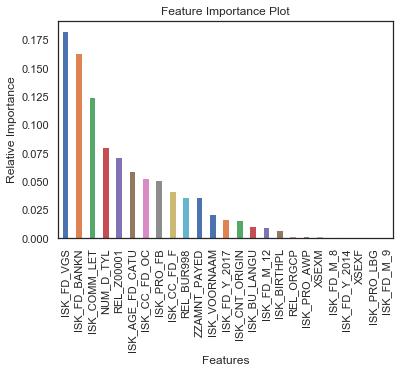

In [63]:
feat_importances = pd.Series(rf.feature_importances_, index=list(optimized_columns_rf))
feat_importances.nlargest(25).plot(kind='bar')
plt.title('Feature Importance Plot')
plt.ylabel('Relative Importance')
plt.xlabel('Features')

Plot a correlation plot with the top 25 features with highest feature importance used by Random Forest Classifier.

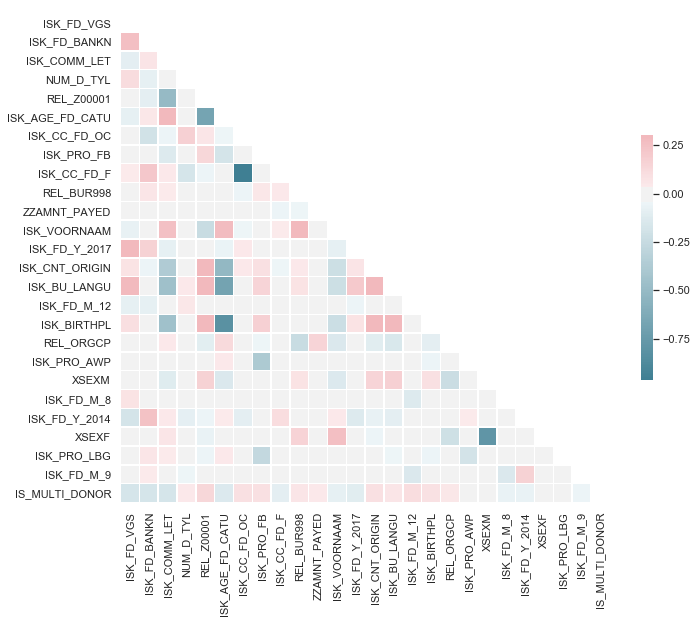

In [64]:
rg_top25_coeffs_cols = list(feat_importances.nlargest(25).index) + ['IS_MULTI_DONOR']
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(question2_prepared_data[rg_top25_coeffs_cols])

# Logistic Regression

In [20]:
#Logistic Regression Baseline
train_X_bl, test_X_bl, train_y_bl, test_y_bl = train_test_split(question2_prepared_data[list(train_cols)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X_bl.shape)

lr = LogisticRegression()
lr.fit(train_X_bl,train_y_bl)

lr_predictions = lr.predict(test_X_bl)
lr_mc = matthews_corrcoef(lr_predictions, test_y_bl)
df = pd.DataFrame({"a":test_y,"b":lr_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ')
print(lr_mc)

(45517, 119)
TP = 882
FP = 369
FN = 2038
TN = 8091
Accuracy = 0.7884885764499121
Precision = 0.7050359712230215
Recall = 0.30205479452054795
F1 = 0.4229201630304483

Matthews Correlation: 
0.360844971173802


## Feature Selection - Logistic Regression

In [30]:
#Recursive Feature Elimination (RFE) 
X, t_X, Y, ty = train_test_split(question2_prepared_data[list(train_cols)], 
                                 question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)

lr = LogisticRegression()
selector_lr = RFECV(lr, cv=5,scoring='recall')
selector_lr.fit(X, Y)
optimized_columns_lr = X.columns[selector_lr.support_]
print(optimized_columns_lr)

Index(['XSEXF', 'XSEXM', 'ISK_PERSON', 'ISK_BIRTHPL', 'ISK_BU_LANGU',
       'ISK_CNT_ORIGIN', 'ISK_NATIONALITY', 'ISK_VOORNAAM', 'ISK_LANGU_CORR',
       'ISK_MARST',
       ...
       'ZLUF_KERKELIJK', 'ZLUF_LIJST', 'ZLUF_ORG_ALS_PERSOON',
       'ZLUF_ORG_VERENIGING', 'ZLUF_SCHENKINTERESSE_ARTnCULTURE',
       'ZLUF_SCHENKINTERESSE_CHILDREN', 'ZLUF_SCHENKINTERESSE_DEVCOOP',
       'ZLUF_SCHENKINTERESSE_HEALTHCARE', 'ZLUF_SCHENKINTERESSE_HERITAGE',
       'ZLUF_SCHENKINTERESSE_SCHOLARSHIPS'],
      dtype='object', length=118)


In [31]:
#Logistic Regression + Feature Selection
train_X_fs, test_X_fs, train_y_fs, test_y_fs = train_test_split(question2_prepared_data[list(optimized_columns_lr)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(test_X_fs.shape)

lr = LogisticRegression()
lr.fit(train_X_fs,train_y_fs)

lr_predictions = lr.predict(test_X_fs)
lr_mc = matthews_corrcoef(lr_predictions, test_y_fs)
df = pd.DataFrame({"a":test_y,"b":lr_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(lr_mc))

(11380, 118)
TP = 870
FP = 366
FN = 2050
TN = 8094
Accuracy = 0.7876977152899824
Precision = 0.7038834951456311
Recall = 0.2979452054794521
F1 = 0.41867179980750724

Matthews Correlation: 0.35748873202297043


## Hyper-parameter tuning - Logistic Regression

In [32]:
#Hyper-parameter tuning for Logistic Regression using RamdomizedSearchCV
tol=[0.001,0.01, 0.1,0.0001]
c = [1.0,2.0,5.0,10.0]
fit_intercept = [True,False]
intercept_scaling = [1,2,3,4,5]
class_weight = ['balanced',None]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [50,100,200]
random_grid = {'tol': tol,
               'C': c,
               'fit_intercept': fit_intercept,
               'intercept_scaling': intercept_scaling,
               'class_weight': class_weight,
               'solver': solver,
               'max_iter': max_iter}
lr = LogisticRegression()
random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, n_iter = 500, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1, scoring='f1')
random.fit(train_X, train_y)
random.best_params_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 79.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 81.2min finished


{'tol': 0.0001,
 'solver': 'liblinear',
 'max_iter': 200,
 'intercept_scaling': 5,
 'fit_intercept': True,
 'class_weight': 'balanced',
 'C': 1.0}

In [ ]:
#Hyper-parameter tuning for Logistic Regression using GridSearchCV
lr = LogisticRegression()
random = GridSearchCV(estimator = lr, param_grid = random_grid, n_iter = 500, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1, scoring='precision')
random.fit(train_X, train_y)
random.best_params_

In [33]:
#Logistic Regression + Feature Selection + Hyperparameter Tuning
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[list(optimized_columns_lr)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(test_X.shape)
lr = LogisticRegression(tol=0.0001,solver='liblinear',max_iter=200,intercept_scaling=5,fit_intercept=True,
                       class_weight='balanced',C=1.0)
lr.fit(train_X,train_y)

lr_predictions = lr.predict(test_X)
lr_mc = matthews_corrcoef(lr_predictions, test_y)
df = pd.DataFrame({"a":test_y,"b":lr_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(lr_mc))

(11380, 118)
TP = 1920
FP = 2466
FN = 1000
TN = 5994
Accuracy = 0.6954305799648506
Precision = 0.4377564979480164
Recall = 0.6575342465753424
F1 = 0.5255954010402409

Matthews Correlation: 0.3284836985439656


In [57]:
lr_coef = lr.coef_
lr_coef = [np.abs(item) for sublist in lr_coef for item in sublist]
coef_weights = pd.DataFrame({"Cols":list(optimized_columns_lr),"Coef":lr_coef})
coef_weights = coef_weights.sort_values("Coef",ascending=False)
coef_weights.reset_index(drop=True,inplace=True)
coef_weights.head()

,Cols,Coef
0,ISK_FD_Y_2018,2.196000
1,ISK_FD_Y_2002,2.178980
2,ISK_TITLE,1.366694
3,ZLUF_ORG_ALS_PERSOON,1.179913
4,ISK_FD_Y_2003,1.115440


Plot a correlation plot with the top 25 features with highest absolute weight coefficients from Logitstic Regression Classifier.

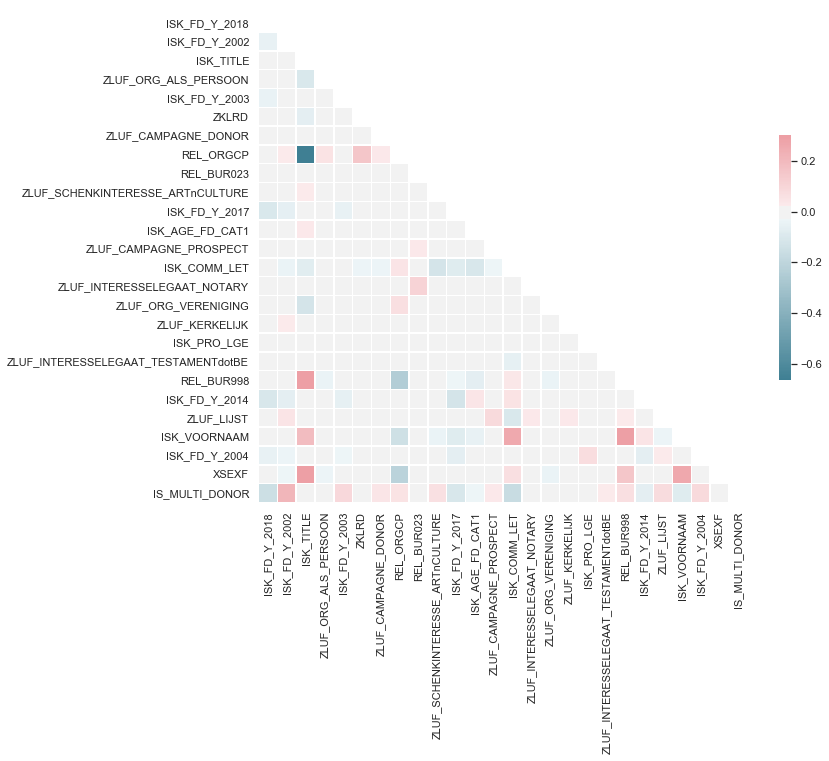

In [56]:
lr_top25_coeffs_cols = list(coef_weights['Cols'][:25]) + ['IS_MULTI_DONOR']

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(question2_prepared_data[lr_top25_coeffs_cols])

One reason why ISK_FD_Y_2002 (Is the first donation in 2002) is correlated with being a multi-donor is because of the archaelogical credit (Sagalassos Research Project). <br>
There is a negative correlation of ISK_FD_Y_2018 (Is the first donation in 2018) with being a multi-donor and it is expected because some of the multi-donors take time to donate again. Some multi-donors who first made a donation in 2018 might donate again in 2018 but the majority of them don't.  

## Apply PCA & Classify using SVM

In [18]:
#Apply PCA
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[train_cols], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
n_components = 30      #30 seems optimal. 20 is good as well 
# Standardizing the features
#train_X = StandardScaler().fit_transform(train_X)
#test_X = StandardScaler().fit_transform(test_X)
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_X)

X_train_pca = pca.transform(train_X)
X_test_pca = pca.transform(test_X)

In [19]:
#SVM
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)   #Takes time. Didn't finish after 2 hours
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca, train_y)
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)
svm_predictions = clf.predict(X_test_pca)

svm_mc = matthews_corrcoef(svm_predictions, test_y)

df = pd.DataFrame({"a":test_y,"b":svm_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(svm_mc))

TP = 1883
FP = 2125
FN = 1037
TN = 6335
Accuracy = 0.7221441124780317
Precision = 0.469810379241517
Recall = 0.6448630136986301
F1 = 0.5435912240184757

Matthews Correlation: 0.35996851905916205


In [53]:
print(abs( pca.components_[0]>0.5)) #3rd component corresponds to 'ISK_PERSON' feature

[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


<b>Logistic Regression</b> produced the best results according to the requirement. <br>
It produced a recall of almost 66% achieving an accuracy of ~70%, meaning it was able to capture almost 2/3rd of donors who would become multi-donors in the future while minimizing false positives as much as possible. <br>

Next steps: <br>
- Try to extract some more features using the LUF data.
- Try other classifiers including Neural Network via Keras.